# Customer Segmentation & Personalized Marketing System

In [49]:
from IPython.display import Image
Image(url="https://www.cleartouch.in/wp-content/uploads/2023/02/Customer-Segmentation.png")


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

**Loading the Dataset**

Loading the **Online Retail dataset** using `pandas`.  
The dataset is encoded using **ISO-8859-1**,because the file contains special characters (such as accented letters) that cannot be properly decoded using the UTF-8 encoding

In [51]:
df=pd.read_csv('/content/OnlineRetail.csv', encoding='ISO-8859-1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [52]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Large negative values in Quantity indicate product returns or cancellations

large number of null values in CustomerID



In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [54]:
#dropping the null values
null_columns=['Description','CustomerID']
for i in null_columns:
    df=df.dropna(subset=[i])

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [56]:
#percentile capping
p_low=df['UnitPrice'].quantile(0.01)
p_high=df['UnitPrice'].quantile(0.99)
df=df[(df['UnitPrice']>=p_low) & (df['UnitPrice']<=p_high)]

Invoices that begin with the letter **C** represent cancelled transactions




In [57]:
returns_df=df[df['InvoiceNo'].astype(str).str.startswith('C')]
sales_df=df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [58]:
sales_df.shape

(391394, 8)

In [59]:
returns_df.shape

(8503, 8)

In [60]:
df=sales_df.copy()

In [61]:
df['CustomerID'].nunique()

4327

***Feature Engineering***


In [62]:
df['Totalprice']=df['Quantity']*df['UnitPrice']

In [63]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [64]:
reference_date = df['InvoiceDate'].max() + timedelta(days=1)

Creating Recency, Frequency, Monetary features

In [65]:
rfm=df.groupby('CustomerID').agg({
    'InvoiceDate':['max', lambda x: (reference_date - x.max()).days],
    'InvoiceNo':'nunique',
    'Totalprice':'sum'
}).reset_index()

rfm.columns=['CustomerID','LastPurchaseDate','Recency','Frequency','Monetary']

In [66]:
rfm

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,326,1,77183.60
1,12347.0,2011-12-07 15:52:00,2,7,4310.00
2,12348.0,2011-09-25 13:13:00,75,4,1437.24
3,12349.0,2011-11-21 09:51:00,19,1,1353.80
4,12350.0,2011-02-02 16:01:00,310,1,294.40
...,...,...,...,...,...
4322,18280.0,2011-03-07 09:52:00,278,1,180.60
4323,18281.0,2011-06-12 10:53:00,181,1,46.92
4324,18282.0,2011-12-02 11:43:00,8,2,178.05
4325,18283.0,2011-12-06 12:02:00,4,16,2078.93


Creating additional behavioral features

In [67]:
behavioral=df.groupby('CustomerID').agg({
    'Quantity':'sum',
    'InvoiceNo':'nunique',
    'Totalprice':['sum','mean','std'],
    'StockCode':'nunique',
    'InvoiceDate':lambda x: (x.max()-x.min()).days
}).reset_index()

behavioral.columns=['CustomerID','TotalQuantity','NumOrders','Totalsales',
                      'AvgOrderPrice','StdOrderPrice','UniqueProducts','CustomerLifetime']

behavioral['AvgBasketSize']=behavioral['TotalQuantity']/behavioral['NumOrders']
behavioral['OrderFrequency']=behavioral['NumOrders']/(behavioral['CustomerLifetime'] + 1)
behavioral['StdOrderPrice']=behavioral['StdOrderPrice'].fillna(0)

In [68]:
behavioral

,CustomerID,TotalQuantity,NumOrders,Totalsales,AvgOrderPrice,StdOrderPrice,UniqueProducts,CustomerLifetime,AvgBasketSize,OrderFrequency
0,12346.0,74215,1,77183.60,77183.600000,0.000000,1,0,74215.000000,1.000000
1,12347.0,2458,7,4310.00,23.681319,23.289902,103,365,351.142857,0.019126
2,12348.0,2332,4,1437.24,53.231111,37.159075,21,282,583.000000,0.014134
3,12349.0,625,1,1353.80,19.340000,10.029097,70,0,625.000000,1.000000
4,12350.0,196,1,294.40,18.400000,5.214211,16,0,196.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
4322,18280.0,45,1,180.60,18.060000,3.380319,10,0,45.000000,1.000000
4323,18281.0,52,1,46.92,9.384000,5.963378,5,0,52.000000,1.000000
4324,18282.0,103,2,178.05,14.837500,5.853579,12,118,51.500000,0.016807
4325,18283.0,1396,16,2078.93,2.753550,2.506013,262,333,87.250000,0.047904


Merge rfm and behavioral into single dataframe

In [69]:
features=pd.merge(
    rfm,
    behavioral[['CustomerID','AvgBasketSize','AvgOrderPrice','UniqueProducts',
                'CustomerLifetime','OrderFrequency']],
    on='CustomerID'
)

In [70]:
features

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,AvgBasketSize,AvgOrderPrice,UniqueProducts,CustomerLifetime,OrderFrequency
0,12346.0,2011-01-18 10:01:00,326,1,77183.60,74215.000000,77183.600000,1,0,1.000000
1,12347.0,2011-12-07 15:52:00,2,7,4310.00,351.142857,23.681319,103,365,0.019126
2,12348.0,2011-09-25 13:13:00,75,4,1437.24,583.000000,53.231111,21,282,0.014134
3,12349.0,2011-11-21 09:51:00,19,1,1353.80,625.000000,19.340000,70,0,1.000000
4,12350.0,2011-02-02 16:01:00,310,1,294.40,196.000000,18.400000,16,0,1.000000
...,...,...,...,...,...,...,...,...,...,...
4322,18280.0,2011-03-07 09:52:00,278,1,180.60,45.000000,18.060000,10,0,1.000000
4323,18281.0,2011-06-12 10:53:00,181,1,46.92,52.000000,9.384000,5,0,1.000000
4324,18282.0,2011-12-02 11:43:00,8,2,178.05,51.500000,14.837500,12,118,0.016807
4325,18283.0,2011-12-06 12:02:00,4,16,2078.93,87.250000,2.753550,262,333,0.047904


Histograms for Customer Features


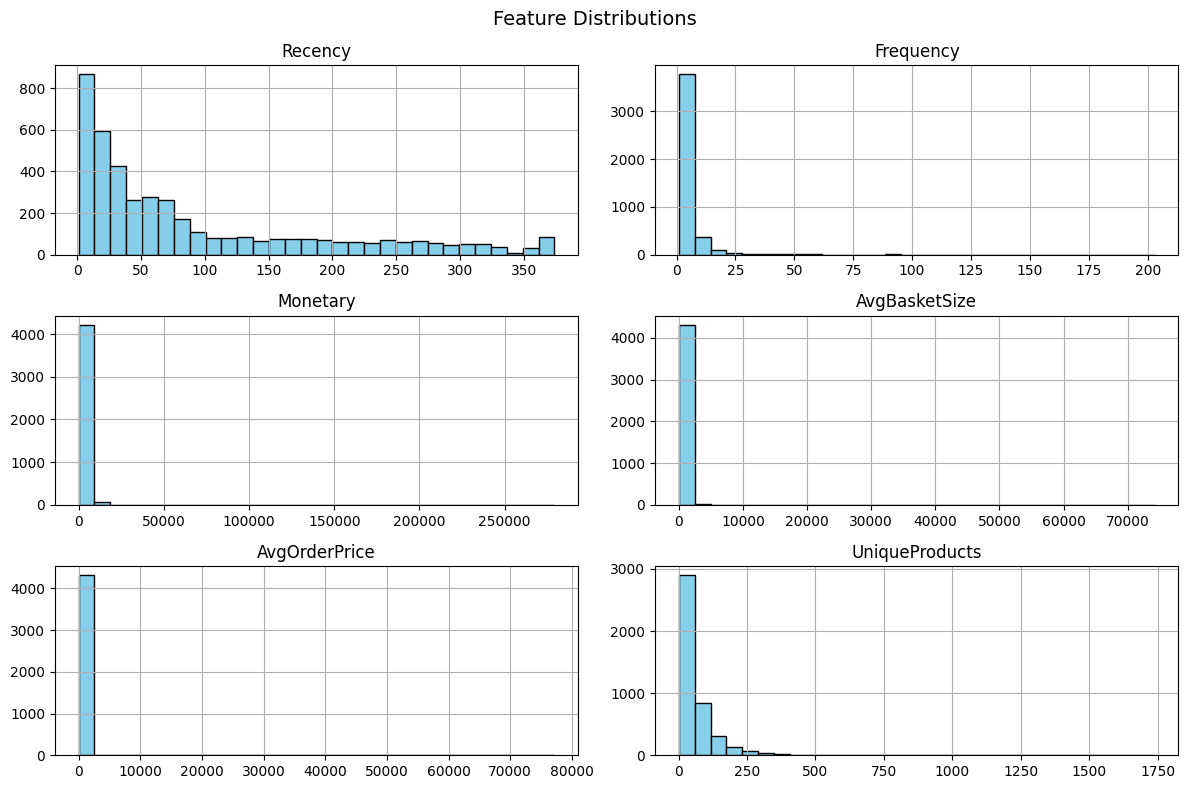

In [71]:
features[['Recency','Frequency','Monetary','AvgBasketSize','AvgOrderPrice','UniqueProducts']].hist(
    bins=30,figsize=(12,8),color='skyblue',edgecolor='black')
plt.suptitle("Feature Distributions",fontsize=14)
plt.tight_layout()
plt.show()

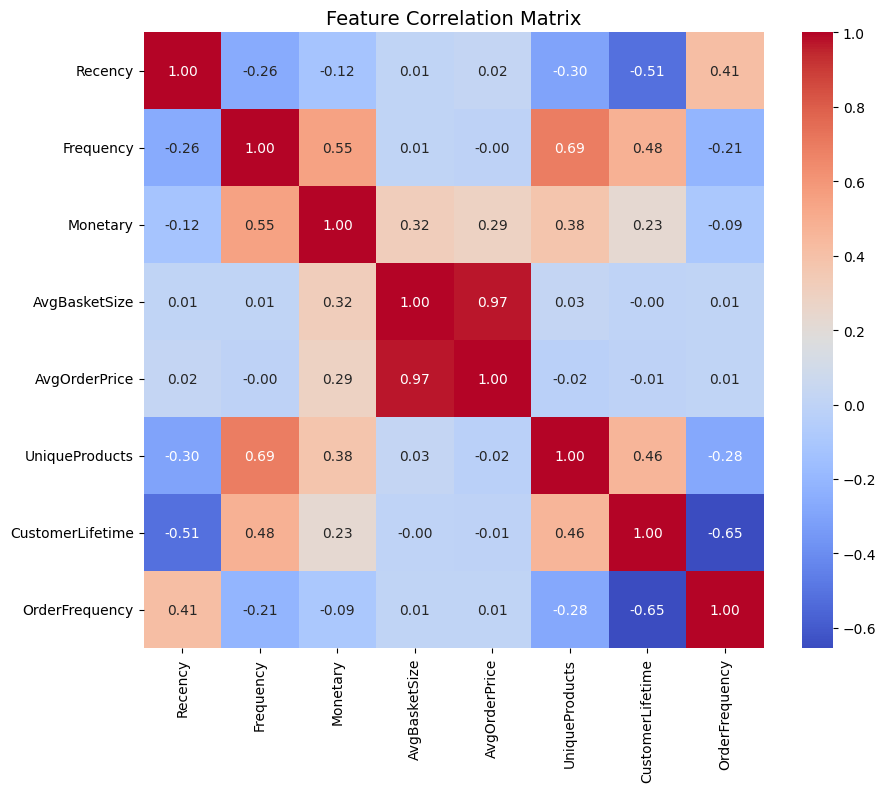

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(features.drop(['CustomerID','LastPurchaseDate'],axis=1).corr(),
            annot=True,fmt=".2f",cmap='coolwarm')
plt.title("Feature Correlation Matrix", fontsize=14)
plt.show()

[Recency,Frequency,Monetary,AvgBasketSize,AvgOrderPrice,UniqueProducts] are useful features here

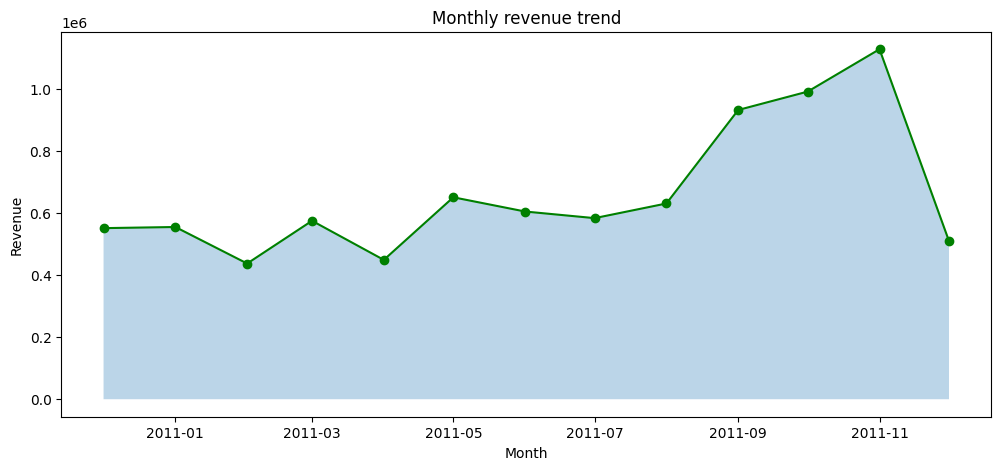

In [73]:
df['YearMonth']=df['InvoiceDate'].dt.to_period('M')
monthly=df.groupby('YearMonth').agg({'Totalprice': 'sum','CustomerID':'nunique'}).reset_index()
monthly['YearMonth']=monthly['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12, 5))
plt.plot(monthly['YearMonth'], monthly['Totalprice'],marker='o',color='green')
plt.fill_between(monthly['YearMonth'],monthly['Totalprice'],alpha=0.3)
plt.title("Monthly revenue trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

strong seasonality in customer purchases.

applying standardscaler to useful features

In [74]:
X=features[['Recency','Frequency','Monetary','AvgBasketSize','AvgOrderPrice','UniqueProducts']]
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [75]:
X_scaled.shape

(4327, 6)

Elbow and silhouette score plot

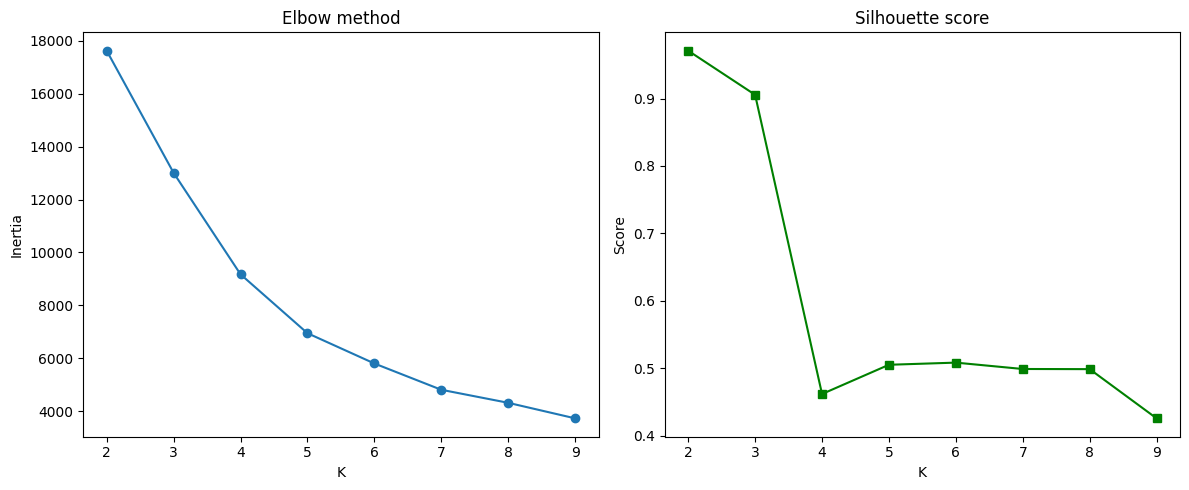

In [76]:
sil_scores=[]
inertias=[]
K = range(2, 10)

for k in K:
    model=KMeans(n_clusters=k,random_state=42,n_init=10)
    labels =model.fit_predict(X_scaled)
    sil =silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    inertias.append(model.inertia_)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(K,inertias,marker='o')
plt.title('Elbow method')
plt.xlabel('K')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, sil_scores,marker='s',color='green')
plt.title('Silhouette score')
plt.xlabel('K')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

taking best_k=6

elbow method bends cleanly around 5-6

silhouette score stabilizes around 0.50 starting at K=6





In [77]:
best_k=6
kmeans=KMeans(n_clusters=best_k,random_state=42,n_init=10)
features['Segment']=kmeans.fit_predict(X_scaled)


In [78]:
counts=features['Segment'].value_counts()
print("Initial segment counts:")
print(counts)

Initial segment counts:
Segment
0    2791
1    1049
5     473
4       6
3       6
2       2
Name: count, dtype: int64


clusters with lesser than 30 customers are labelled as outlier

In [79]:
min_size=30
small_clusters=counts[counts<min_size].index
features['Segment'] = features['Segment'].apply(lambda x: 'Outlier' if x in small_clusters else x)

features['Segment'].value_counts()

,count
Segment,
0,2791
1,1049
5,473
Outlier,14


Principal Component Analysis

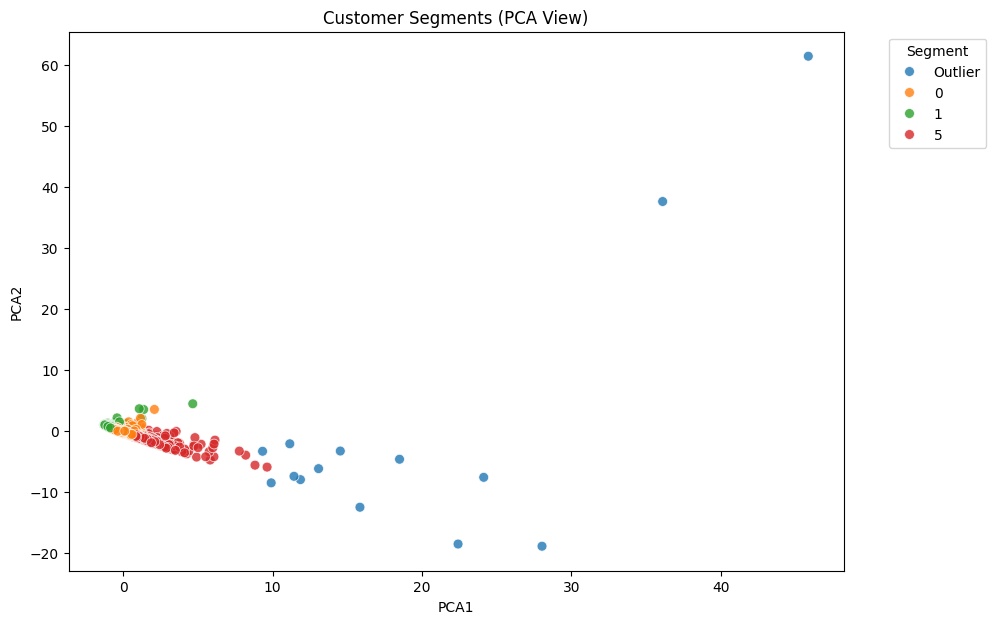

In [80]:
pca=PCA(n_components=2, random_state=42)
X_pca=pca.fit_transform(X_scaled)
features['PCA1']=X_pca[:, 0]
features['PCA2']=X_pca[:, 1]

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=features,
    x='PCA1',y='PCA2',
    hue='Segment',
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title("Customer Segments (PCA View)")
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

PCA shows that the main customer segments cluster closely together

but few customers lie far away and are correctly identified as outliers

In [92]:
print(f"{'*'*200}")

********************************************************************************************************************************************************************************************************


calculated the average behavioral and rfm characteristics for each main customer segment

In [81]:
main_segments=features[features['Segment'] != 'Outlier']
profile=main_segments.groupby('Segment').agg({
    'CustomerID':'count',
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'AvgBasketSize':'mean',
    'AvgOrderPrice':'mean',
    'UniqueProducts':'mean',
    'CustomerLifetime':'mean',
    'OrderFrequency':'mean'
}).round(2)
profile.columns= ['Count','Recency','Frequency','Monetary','AvgBasketSize',
                   'AvgOrderPrice','UniqueProducts','CustomerLifetime','OrderFrequency']


profile

,Count,Recency,Frequency,Monetary,AvgBasketSize,AvgOrderPrice,UniqueProducts,CustomerLifetime,OrderFrequency
Segment,,,,,,,,,
0,2791,46.42,3.25,1111.27,216.73,30.05,47.53,139.52,0.33
1,1049,249.91,1.56,494.87,180.90,43.50,23.86,26.40,0.76
5,473,17.42,13.91,7065.35,318.98,29.52,201.55,300.73,0.05


assigning each segment acustomer persona based on its average recency, frequency,and monetary values

In [93]:

personas = {}

for seg in profile.index:
    rec = profile.loc[seg, 'Recency']
    freq = profile.loc[seg, 'Frequency']
    mon = profile.loc[seg, 'Monetary']

    if freq > profile['Frequency'].mean() and mon > profile['Monetary'].mean():
        personas[seg] = "VIP Customers"
    elif freq > profile['Frequency'].mean() and mon <= profile['Monetary'].mean():
        personas[seg] = "Loyal Mid-Spenders"
    elif rec < profile['Recency'].mean():
        personas[seg] = "New/Active Customers"
    elif rec > profile['Recency'].mean() and mon < profile['Monetary'].mean():
        personas[seg] = "At-Risk Customers"
    else:
        personas[seg] = "Occasional Shoppers"

personas['Outlier'] = "Other Customers"

for seg, name in personas.items():
    print(f"\nSegment {seg}: {name}")



Segment 0: New/Active Customers

Segment 1: At-Risk Customers

Segment 5: VIP Customers

Segment Outlier: Other Customers


marketing stratergy and recommendations for each segments

In [83]:
for seg, name in personas.items():
    print(f"\nSegment {seg}: {name}")

    if "VIP" in name:
        print(" Strategy: Keep them happy and loyal")
        print("   - Give them early access to new products or sales")
        print("   - Offer special rewards or gifts")
        print("   - Make them feel important and valued")

    elif "Loyal" in name:
        print(" Strategy: Help them spend a bit more")
        print("   - Suggest related products or bundles")
        print("   - Give discounts for buying more items")
        print("   - Reward them for staying loyal")

    elif "New" in name or "Active" in name:
        print(" Strategy: Welcome and educate them")
        print("   - Send a welcome email or discount for first order")
        print("   - Show how your products can help them")
        print("   - Make them feel excited about joining your brand")

    elif "At-Risk" in name:
        print(" Strategy: Bring them back")
        print("   - Send a friendly reminder or special offer")
        print("   - Use time-limited discounts to grab attention")
        print("   - Ask for feedback to understand why they stopped buying")

    else:
        print(" Strategy: Keep them engaged")
        print("   - Encourage them to buy again with seasonal offers")
        print("   - Use referral or points programs")
        print("   - Send updates about new arrivals or deals")



Segment 0: New/Active Customers
 Strategy: Welcome and educate them
   - Send a welcome email or discount for first order
   - Show how your products can help them
   - Make them feel excited about joining your brand

Segment 1: At-Risk Customers
 Strategy: Bring them back
   - Send a friendly reminder or special offer
   - Use time-limited discounts to grab attention
   - Ask for feedback to understand why they stopped buying

Segment 5: VIP Customers
 Strategy: Keep them happy and loyal
   - Give them early access to new products or sales
   - Offer special rewards or gifts
   - Make them feel important and valued

Segment Outlier: Other Customers
 Strategy: Keep them engaged
   - Encourage them to buy again with seasonal offers
   - Use referral or points programs
   - Send updates about new arrivals or deals


exporting all customer features,segment profiles,and persona labels into a single excel file

In [84]:
output_file='Customer_Segmentation_Results.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:

    features_export=features.copy()
    features_export['LastPurchaseDate']=features_export['LastPurchaseDate'].dt.strftime('%Y-%m-%d')
    features_export.to_excel(writer, sheet_name='Customer_Features',index=False)

    profile.to_excel(writer, sheet_name='Segment_Profile')


    persona_df=pd.DataFrame([
        {'Segment': seg,'Persona': name}
        for seg, name in personas.items()
    ])
    persona_df.to_excel(writer,sheet_name='Personas',index=False)

print(f"\nData saved to Excel file: {output_file}")


Data saved to Excel file: Customer_Segmentation_Results.xlsx
